In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/perez/anaconda3/bin/python -m pip install --upgrade pip' command.


### MULTIVARIATE GAUSSIAN DISTRIBUTION dim=2

Substituting symbol N from STIXNonUnicode
Substituting symbol N from STIXNonUnicode


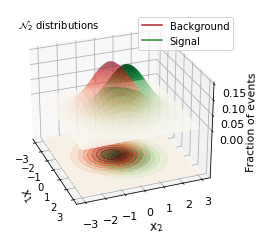

In [4]:
# PLOT 2 MULTIVARIATE GAUSSIAN DISTRIBUTIONS

# Our 2-dimensional distribution will be over variables X and Y
N = 80
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0.3, 0.3])
mu2 = np.array([-0.3, -0.3])
Sigma = np.array([[ 1. , 0], [0,  1]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)
Z2 = multivariate_gaussian(pos, mu2, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')

z_aux = np.linspace(2, 2, 2)
x_aux = z_aux
y_aux = z_aux

ax.plot(x_aux, y_aux, z_aux, color='firebrick', label='Background')
ax.plot(x_aux, y_aux, z_aux, color='forestgreen', label='Signal')
ax.legend(loc={0.6,0.8})

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.Greens)
ax.plot_surface(X, Y, Z2, rstride=3, cstride=3, linewidth=1, antialiased=True,alpha=0.4,
                cmap=cm.Reds)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.Greens)
cset2 = ax.contourf(X, Y, Z2, zdir='z', offset=-0.15, cmap=cm.Reds,alpha=0.5)

# Adjust the limits, ticks and view angle
ax.set_facecolor("white")
ax.set_zlim(-0.15,0.15)
ax.set_zticks(np.linspace(0,0.15,4))
ax.view_init(27, -21)
plt.xlabel("$x_1$",fontsize=12)
plt.ylabel("$x_2$",fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
ax.zaxis.set_tick_params(labelsize=11)

ax.text2D(0.05, 0.9, "$\mathcal{N}_{2}$ distributions", transform=ax.transAxes)
ax.text2D(1.1, 0.25, "Fraction of events", transform=ax.transAxes, rotation=89, fontsize=11)
#plt.savefig('images/' + '2gaussian-distributions.pdf', format="pdf", bbox_inches="tight")
plt.show()

### Gaussians

In [5]:
##############
# PARAMETERS #
##############

# gaussian, mean
epsilon = 0.3

# number of events
N = 1000000

# requested number of ensembles
n_ensembles = 5000

# number of expected background events per ensemble
B_expected = 50000

# ratio S_expected/B_expected (signal ratio)
SB_ratio = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075]





# SOME USEFUL DERIVATED PARAMETERS:

# S_expected:
S_expected = [ int(SB_ratio[iii]*B_expected) for iii in range(len(SB_ratio)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(SB_ratio)) ]

(1000000, 2)
(1000000, 1)
(1000000, 2)
(1000000, 1)


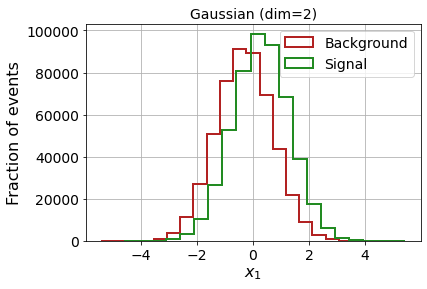

In [6]:
#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=2)",fontsize=14)
plt.show()  

### XGBoost (per-event)

/home/perez/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/perez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/perez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y

[0]	validation_0-logloss:0.67908	validation_1-logloss:0.67925
[1]	validation_0-logloss:0.66738	validation_1-logloss:0.66771
[2]	validation_0-logloss:0.65795	validation_1-logloss:0.65841
[3]	validation_0-logloss:0.64994	validation_1-logloss:0.65051
[4]	validation_0-logloss:0.64329	validation_1-logloss:0.64398
[5]	validation_0-logloss:0.63782	validation_1-logloss:0.63860
[6]	validation_0-logloss:0.63322	validation_1-logloss:0.63410
[7]	validation_0-logloss:0.62935	validation_1-logloss:0.63034
[8]	validation_0-logloss:0.62613	validation_1-logloss:0.62719
[9]	validation_0-logloss:0.62340	validation_1-logloss:0.62454
[10]	validation_0-logloss:0.62114	validation_1-logloss:0.62234
[11]	validation_0-logloss:0.61924	validation_1-logloss:0.62051
[12]	validation_0-logloss:0.61762	validation_1-logloss:0.61895
[13]	validation_0-logloss:0.61628	validation_1-logloss:0.61765
[14]	validation_0-logloss:0.61511	validation_1-logloss:0.61654
[15]	validation_0-logloss:0.61421	validation_1-logloss:0.61567
[1

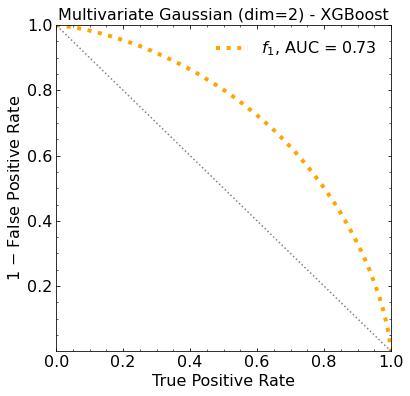

In [7]:
# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Multivariate Gaussian (dim=2) - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

Classification score:


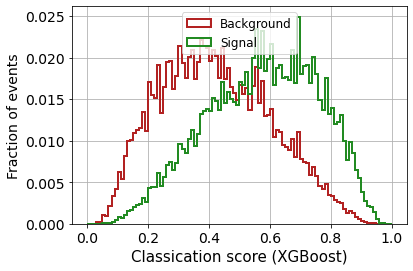

Classification score interpolation:


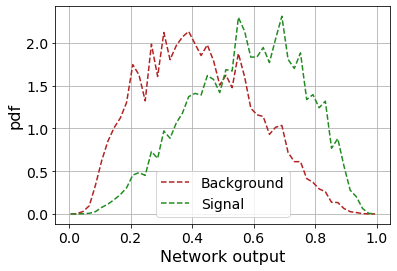

In [8]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="upper center")
#plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("pdf",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

###### Example of ensemble

/home/perez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


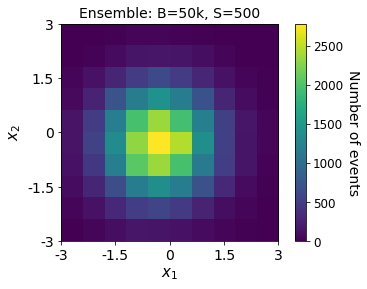

In [9]:
# Plot 1 ensemble with B=50k events and S=500 events
# how an experiment would look like for a measurement of B=50k and S=500 including binning

hist, xbins, ybins = np.histogram2d(np.concatenate([X_gauss_val_SM[:50000],X_gauss_val_NP[:500]])[:,1], np.concatenate([X_gauss_val_SM[:50000],X_gauss_val_NP[:500]])[:,0], bins=(10, 10), range = [[-3,3],[-3,3]])

im = plt.imshow(hist,interpolation='none')
plt.gca().invert_yaxis() 
cbar = plt.colorbar()
cbar.ax.set_ylabel('Number of events', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 17
cbar.ax.tick_params(labelsize=12)

ax = plt.subplot(111)
bins_labelsx = [-0.5,2,4.5,7,9.5]
namesx = ['-3','-1.5','0','1.5','3']
ax.set_xticks(bins_labelsx)
ax.set_xticklabels(namesx)
bins_labelsy = [-0.5,2,4.5,7,9.5]
namesy = ['-3','-1.5','0','1.5','3']
ax.set_yticks(bins_labelsy)
ax.set_yticklabels(namesy)
plt.xlabel('$x_1$',fontsize=15)
plt.ylabel('$x_2$',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Ensemble: B=50k, S=500', fontsize=14)
#plt.savefig('images/' + '2gaussian-ensemble-example.pdf', format="pdf", bbox_inches="tight")
plt.show()

## METHODS to calculate Z

### 1. BINNED POISSON LOG-LIKELIHOOD

#### 1.1 Binning the original parameter space, in this case 2-dimensional (x_1,x_2)

In [10]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################


store_Z_bins = []


for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])

    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(N / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(N / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([background_X_1[:N_events_back],background_X_2[:N_events_back]], bins=(10,10), range = [[-3,3],[-3,3]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([signal_X_1[:N_events_sig],signal_X_2[:N_events_sig]], bins=(10,10), range = [[-3,3],[-3,3]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins.append(Z_bins)

    print('Z_bins : ', Z_bins)
    
    print('\n ----------------------------------- \n')


B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
Z_bins :  0.3117051947149588

 ----------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
Z_bins :  0.7778391648629387

 ----------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
Z_bins :  1.5510096963953577

 ----------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
Z_bins :  2.3196672647523

 ----------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
Z_bins :  3.0838865138801026

 ----------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
Z_bins :  7.583034848413861

 ----------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
Z_bins :  14.792291148355877

 ----------------------------------- 

B_expected:  50000
S_expected:  

In [11]:
print(store_Z_bins)

[0.3117051947149588, 0.7778391648629387, 1.5510096963953577, 2.3196672647523, 3.0838865138801026, 7.583034848413861, 14.792291148355877, 21.695917960562856]


In [10]:
# To use if you dont want to run everything again. Its the previous results
store_Z_bins = [0.3117051947149588, 0.7778391648629387, 1.5510096963953577, 2.3196672647523, 3.0838865138801026, 7.583034848413861, 14.792291148355877, 21.695917960562856]

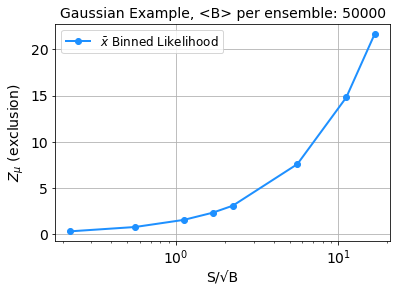

In [12]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### 1.2 Binning the classifier output, always a 1-dimensional space

In [13]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################


store_Z_bins_class = []


for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])

    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(len(pred_XG_SM) / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(len(pred_XG_NP) / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(10), range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP[:N_events_sig]], bins=(10), range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_class.append(Z_bins)

    print('Z_bins : ', Z_bins)
    
    print('\n ----------------------------------- \n')


B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
Z_bins :  0.31394655688099077

 ----------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
Z_bins :  0.7834788898914222

 ----------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
Z_bins :  1.5623355516789794

 ----------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
Z_bins :  2.336693618572312

 ----------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
Z_bins :  3.106868350588861

 ----------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
Z_bins :  7.6407339881205845

 ----------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
Z_bins :  14.90633243091161

 ----------------------------------- 

B_expected:  50000
S_expected:

In [14]:
print(store_Z_bins_class)

[0.31394655688099077, 0.7834788898914222, 1.5623355516789794, 2.336693618572312, 3.106868350588861, 7.6407339881205845, 14.90633243091161, 21.86272295298514]


In [12]:
# To use if you dont want to run everything again. Its the previous results
store_Z_bins_class = [0.31394655688099077, 0.7834788898914222, 1.5623355516789794, 2.336693618572312, 3.106868350588861, 7.6407339881205845, 14.90633243091161, 21.86272295298514]

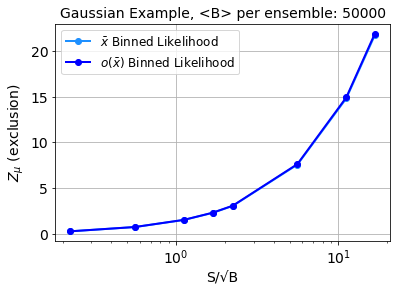

In [15]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 2. TRUE PDF LIKELIHOOD (GAUSSIANS)

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  5000

 If  10010  =  855    then the proposed range has to be extended
n_ensembles (actual):  4255
This may take long...


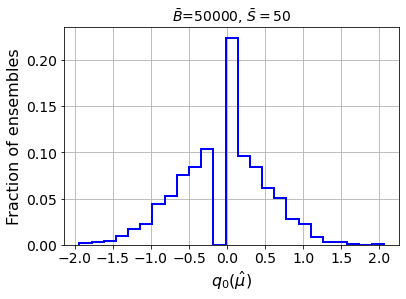

muhat mean:  0.15271445358401878
median q_muhat:  0.0073532685186989966
Z_gaussian:  0.08575120126679857

 ------------------------------------ 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
n_ensembles (initial):  5000

 If  10025  =  856    then the proposed range has to be extended
n_ensembles (actual):  4256
This may take long...


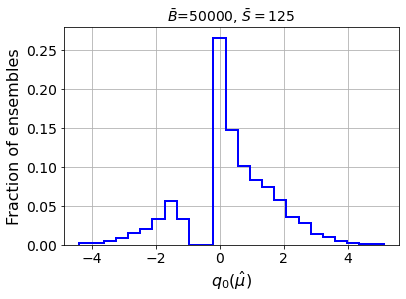

muhat mean:  0.3020911654135338
median q_muhat:  0.2899501355122709
Z_gaussian:  0.5384701807085244

 ------------------------------------ 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  5000

 If  10050  =  856    then the proposed range has to be extended
n_ensembles (actual):  4254
This may take long...


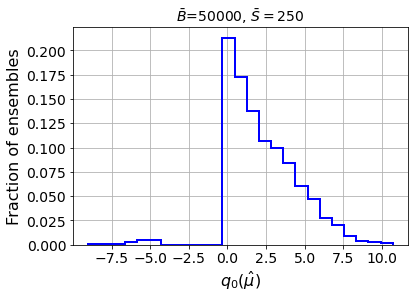

muhat mean:  0.32054536906441
median q_muhat:  1.8407247871439552
Z_gaussian:  1.3567331304069916

 ------------------------------------ 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
n_ensembles (initial):  5000

 If  10075  =  857    then the proposed range has to be extended
n_ensembles (actual):  4256
This may take long...


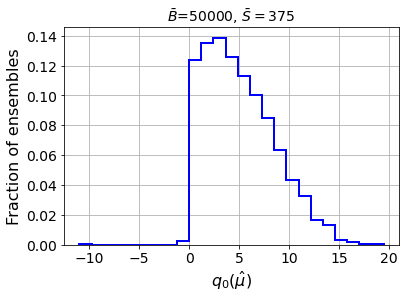

muhat mean:  0.23609022556390977
median q_muhat:  4.529067138750577
Z_gaussian:  2.1281605058713446

 ------------------------------------ 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  5000

 If  10100  =  857    then the proposed range has to be extended
n_ensembles (actual):  4255
This may take long...


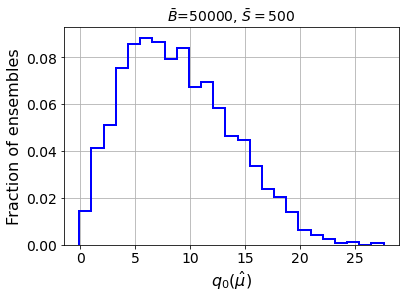

muhat mean:  0.18907168037602823
median q_muhat:  8.51781461357848
Z_gaussian:  2.9185295293312485

 ------------------------------------ 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
n_ensembles (initial):  5000

 If  10250  =  862    then the proposed range has to be extended
n_ensembles (actual):  4261
This may take long...


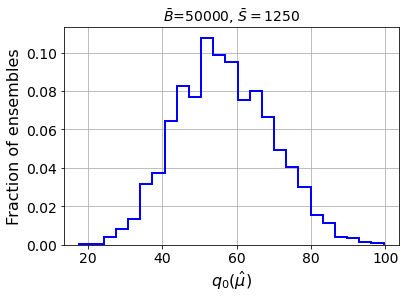

muhat mean:  0.09650316827035908
median q_muhat:  56.04850572429359
Z_gaussian:  7.486554997079337

 ------------------------------------ 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
n_ensembles (initial):  5000

 If  10500  =  869    then the proposed range has to be extended
n_ensembles (actual):  4262
This may take long...


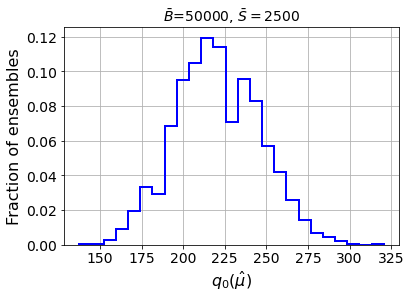

muhat mean:  0.0683247301736274
median q_muhat:  219.17305429363523
Z_gaussian:  14.804494395069195

 ------------------------------------ 

B_expected:  50000
S_expected:  3750
S/$\sqrt{B}$:  16.77050983124842
n_ensembles (initial):  5000

 If  10750  =  878    then the proposed range has to be extended
n_ensembles (actual):  4269
This may take long...


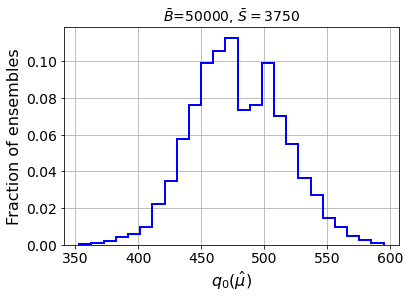

muhat mean:  0.06038884984773952
median q_muhat:  476.5332376519982
Z_gaussian:  21.829641262558535

 ------------------------------------ 



In [16]:
store_muhat_mean_gaussian = []
store_Z_gaussian = []

for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print('S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    
    print('This may take long...')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################
    muhat_selected_list = []
    q_muhat = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

#             # SIGNAL events in an ensemble
#             NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

#             prob_NP_given_B = [] # p_b(S_ensemble)
#             prob_NP_given_S = [] # p_s(S_ensemble)

#             for ll in range(len(NP_shuf)):
#                 prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 ) ) )
#                 prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 ) ) )


            # BACKGROUND events in an ensemble
            SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

            prob_SM_given_B = [] # p_b(B_ensemble)
            prob_SM_given_S = [] # p_s(B_ensemble)

            for ll in range(len(SM_shuf)):
                prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 ) ) )
                prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 ) ) )


            # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
            prob_x_given_B = prob_SM_given_B #+ prob_NP_given_B

            # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
            prob_x_given_S = prob_SM_given_S #+ prob_NP_given_S




            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat should be around 0 for exclusion
            muhat_test = np.arange(0., 1.5, 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 0

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            # DISCOVERY:
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat.append( 2 * ( ( (1.-muhat_selected) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] )
 ) )

    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_gaussian.append(muhat_mean)

    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]
    
    q_muhat_median = np.median(q_muhat)

    Z_gaussian = abs(q_muhat_median)**0.5
    store_Z_gaussian.append(Z_gaussian)

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_gaussian: ', Z_gaussian)


    print('\n ------------------------------------ \n')


In [17]:
print(store_muhat_mean_gaussian)
print(store_Z_gaussian)

[0.15271445358401878, 0.3020911654135338, 0.32054536906441, 0.23609022556390977, 0.18907168037602823, 0.09650316827035908, 0.0683247301736274, 0.06038884984773952]
[0.08575120126679857, 0.5384701807085244, 1.3567331304069916, 2.1281605058713446, 2.9185295293312485, 7.486554997079337, 14.804494395069195, 21.829641262558535]


In [14]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_gaussian = [0.15271445358401878, 0.3020911654135338, 0.32054536906441, 0.23609022556390977, 0.18907168037602823, 0.09650316827035908, 0.0683247301736274, 0.06038884984773952]
store_Z_gaussian = [0.08575120126679857, 0.5384701807085244, 1.3567331304069916, 2.1281605058713446, 2.9185295293312485, 7.486554997079337, 14.804494395069195, 21.829641262558535]

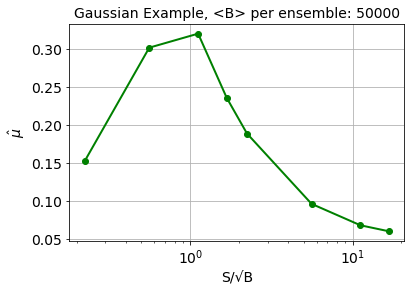

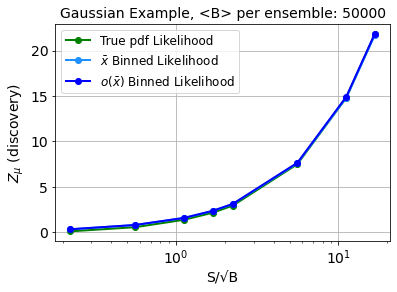

In [18]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label='mu_hat')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.show()






plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 3. MACHINE-LEARNED LIKELIHOOD with Kernel Density Estimator

### KDE 

Substituting symbol N from STIXNonUnicode
Substituting symbol N from STIXNonUnicode
Substituting symbol N from STIXNonUnicode
Substituting symbol N from STIXNonUnicode


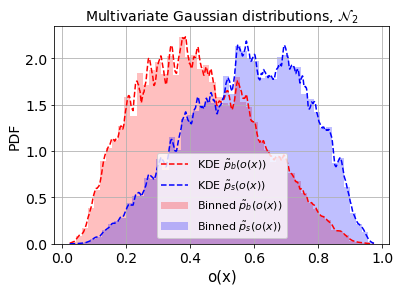

In [19]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

SM_bandwidth = 0.0127
NP_bandwidth = 0.0127

# bandwidth = np.logspace(-4.0, 0, 20)

# kde = KernelDensity(kernel='epanechnikov')
# grid = GridSearchCV(kde, {'bandwidth': bandwidth})
# grid.fit(np.c_[pred_XG_SM[:50000]])
# print('Background: ', grid.best_estimator_)

# SM_bandwidth = grid.best_estimator_.bandwidth



# kde = KernelDensity(kernel='epanechnikov')
# grid = GridSearchCV(kde, {'bandwidth': bandwidth})
# grid.fit(np.c_[pred_XG_NP[:50000]])
# print('Signal: ', grid.best_estimator_)

# NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

B_expected:  50000


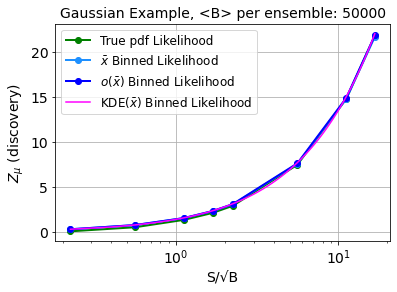

In [20]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ Binned Likelihood') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL + KDE

In [21]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [22]:
KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )

In [23]:
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

In [24]:
# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  5000

 If  10010  =  855    then the proposed range has to be extended
n_ensembles (actual):  4255

 This may take long... 



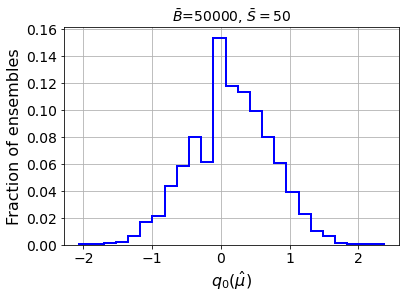

muhat mean:  0.13061104582843713
median q_muhat:  0.14493380474560524
Z_KDE:  0.38070172674366115
Z_KDE_mu0:  0.38070172674366115

 -------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
n_ensembles (initial):  5000

 If  10025  =  856    then the proposed range has to be extended
n_ensembles (actual):  4256

 This may take long... 



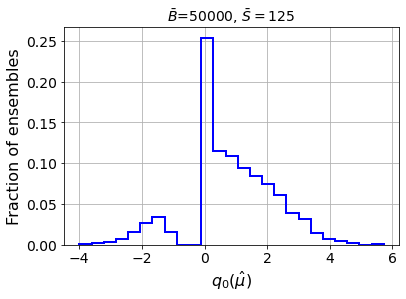

muhat mean:  0.2378782894736842
median q_muhat:  0.7492425732432224
Z_KDE:  0.8655879927790255
Z_KDE_mu0:  0.8655879927790255

 -------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  5000

 If  10050  =  856    then the proposed range has to be extended
n_ensembles (actual):  4254

 This may take long... 



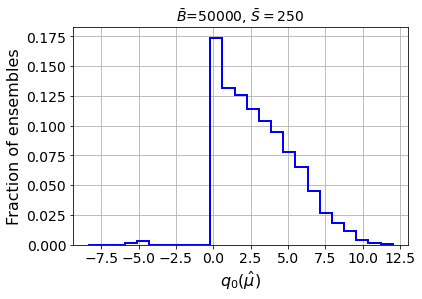

muhat mean:  0.22710625293841089
median q_muhat:  2.704388523622754
Z_KDE:  1.6445025155416315
Z_KDE_mu0:  1.6445025155416315

 -------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
n_ensembles (initial):  5000

 If  10075  =  857    then the proposed range has to be extended
n_ensembles (actual):  4256

 This may take long... 



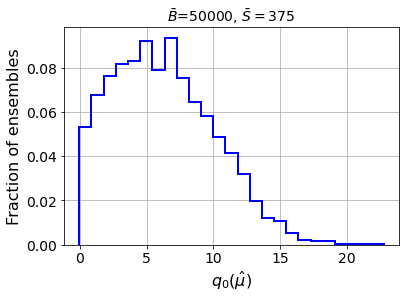

muhat mean:  0.16327537593984964
median q_muhat:  5.949675869429825
Z_KDE:  2.43919574233595
Z_KDE_mu0:  2.43919574233595

 -------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  5000

 If  10100  =  857    then the proposed range has to be extended
n_ensembles (actual):  4255

 This may take long... 



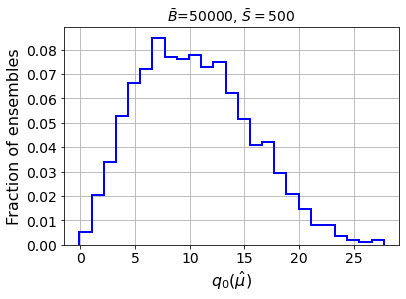

muhat mean:  0.13252643948296122
median q_muhat:  10.118704839194038
Z_KDE:  3.180991172448304
Z_KDE_mu0:  3.180991172448304

 -------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
n_ensembles (initial):  5000

 If  10250  =  862    then the proposed range has to be extended
n_ensembles (actual):  4261

 This may take long... 



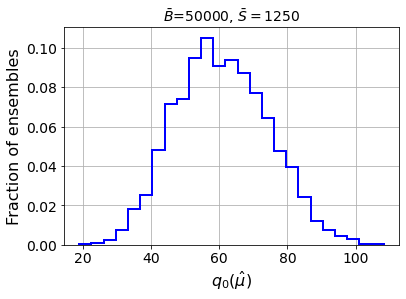

muhat mean:  0.0683172964092936
median q_muhat:  60.52282634102721
Z_KDE:  7.779641787449292
Z_KDE_mu0:  7.779955622720946

 -------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
n_ensembles (initial):  5000

 If  10500  =  869    then the proposed range has to be extended
n_ensembles (actual):  4262

 This may take long... 



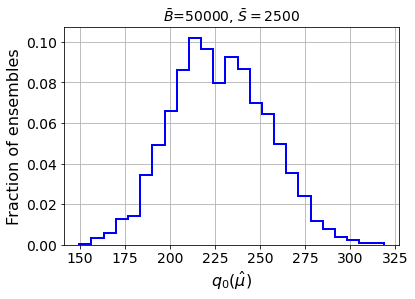

muhat mean:  0.0510793054903801
median q_muhat:  227.09046537163113
Z_KDE:  15.069521073067689
Z_KDE_mu0:  15.078248962638266

 -------------------------------- 

B_expected:  50000
S_expected:  3750
S/$\sqrt{B}$:  16.77050983124842
n_ensembles (initial):  5000

 If  10750  =  878    then the proposed range has to be extended
n_ensembles (actual):  4269

 This may take long... 



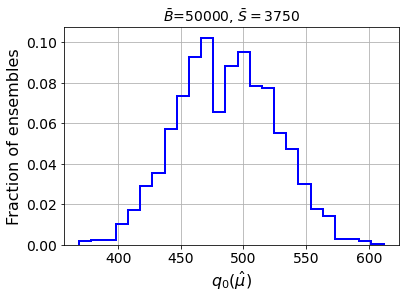

muhat mean:  0.04804403841649098
median q_muhat:  487.28050738130514
Z_KDE:  22.074431077183057
Z_KDE_mu0:  22.087949897321085

 -------------------------------- 



In [25]:
store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_list = []
    q_muhat = []
    q_muhat_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1.5, 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 0.01

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat.append( 2 * ( ( (1.-muhat_selected) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] )
 ) )
            q_muhat_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] )
 ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_mu0 = [x for x in q_muhat_mu0 if x == x]

    q_muhat_median_mu0 = np.median(q_muhat_mu0)

    Z_KDE_mu0 = abs(q_muhat_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    
    
    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean)
    
    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]

    q_muhat_median = np.median(q_muhat)

    Z_KDE = abs(q_muhat_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE_mu0: ', Z_KDE_mu0)

    print('\n -------------------------------- \n')

In [26]:
print(store_muhat_mean_MLL_KDE)
print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

[0.13061104582843713, 0.2378782894736842, 0.22710625293841089, 0.16327537593984964, 0.13252643948296122, 0.0683172964092936, 0.0510793054903801, 0.04804403841649098]
[0.38070172674366115, 0.8655879927790255, 1.6445025155416315, 2.43919574233595, 3.180991172448304, 7.779641787449292, 15.069521073067689, 22.074431077183057]
[0.38070172674366115, 0.8655879927790255, 1.6445025155416315, 2.43919574233595, 3.180991172448304, 7.779955622720946, 15.078248962638266, 22.087949897321085]


In [20]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.13061104582843713, 0.2378782894736842, 0.22710625293841089, 0.16327537593984964, 0.13252643948296122, 0.0683172964092936, 0.0510793054903801, 0.04804403841649098]
store_Z_MLL_KDE = [0.38070172674366115, 0.8655879927790255, 1.6445025155416315, 2.43919574233595, 3.180991172448304, 7.779641787449292, 15.069521073067689, 22.074431077183057]
store_Z_MLL_KDE_mu0 = [0.38070172674366115, 0.8655879927790255, 1.6445025155416315, 2.43919574233595, 3.180991172448304, 7.779955622720946, 15.078248962638266, 22.087949897321085]

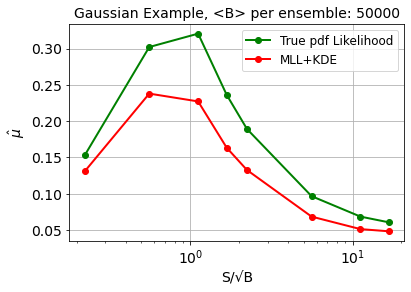

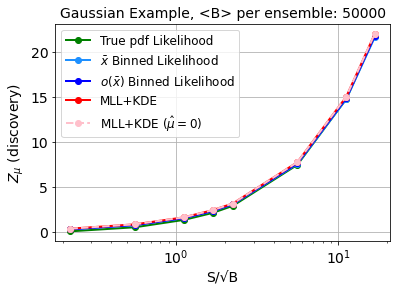

In [27]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()






plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ Binned Likelihood') 
plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_mu0, '--ok', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 4.Working points, counting over 1 bin

In [28]:
WP = [0.25, 0.5, 0.75]

S_expected = [int(SB_ratio[i]*B_expected) for i in range(len(SB_ratio))]

print(S_expected)

[50, 125, 250, 375, 500, 1250, 2500, 3750]


In [29]:
SrootB_WP0 = []
SrootB_WP1 = []
SrootB_WP2 = []


# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

for j in range(len(S_expected)):
    
    # number of signal ensembles
    S_ensembles = int(len(pred_XG_NP)/S_expected[j])

    # shorten the number of S events so I get an integer number of ensembles
    pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected[j]) * S_expected[j]]

    XG_NP_passWP0 = 0
    XG_NP_passWP1 = 0
    XG_NP_passWP2 = 0

    for i in range(len(pred_XG_NP_entero)):
        if pred_XG_NP_entero[i] > WP[0]:
            XG_NP_passWP0 += 1
        if pred_XG_NP_entero[i] > WP[1]:
            XG_NP_passWP1 += 1
        if pred_XG_NP_entero[i] > WP[2]:
            XG_NP_passWP2 += 1

            
    # save the results Z_binned after WP
    SrootB_WP0.append( ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5 )
    SrootB_WP1.append( ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5 )
    SrootB_WP2.append( ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5 )
    
    print('S_expected = ', S_expected[j])
    print('WP: 0     S/B**0.5= ', S_expected[j]/(B_expected)**0.5)
    print('WP: ', WP[0], '    S/B**0.5= ', SrootB_WP0[j] )
    print('WP: ', WP[1], '    S/B**0.5= ', SrootB_WP1[j] )
    print('WP: ', WP[2], '    S/B**0.5= ', SrootB_WP2[j] )
    print('------------------------')
    print('')
    
print('SrootB_WP0: ', SrootB_WP0)
print('SrootB_WP1: ', SrootB_WP1)
print('SrootB_WP2: ', SrootB_WP2)

S_expected =  50
WP: 0     S/B**0.5=  0.22360679774997896
WP:  0.25     S/B**0.5=  0.23786865622293354
WP:  0.5     S/B**0.5=  0.2564679701176723
WP:  0.75     S/B**0.5=  0.20573699998206152
------------------------

S_expected =  125
WP: 0     S/B**0.5=  0.5590169943749475
WP:  0.25     S/B**0.5=  0.5946727040637171
WP:  0.5     S/B**0.5=  0.6411839067612723
WP:  0.75     S/B**0.5=  0.514372192204659
------------------------

S_expected =  250
WP: 0     S/B**0.5=  1.118033988749895
WP:  0.25     S/B**0.5=  1.1893454081274342
WP:  0.5     S/B**0.5=  1.2823678135225447
WP:  0.75     S/B**0.5=  1.028744384409318
------------------------

S_expected =  375
WP: 0     S/B**0.5=  1.6770509831248424
WP:  0.25     S/B**0.5=  1.7840181121911514
WP:  0.5     S/B**0.5=  1.923551720283817
WP:  0.75     S/B**0.5=  1.5431165766139772
------------------------

S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.3787170696234115
WP:  0.5     S/B**0.5=  2.564838046272494


In [26]:
# To use if you dont want to run everything again. Its the previous results
SrootB_WP0 = [0.23786865622293354, 0.5946727040637171, 1.1893454081274342, 1.7840181121911514, 2.3787170696234115, 5.9467926740585275, 11.893585348117055, 17.84043118387555]
SrootB_WP1 = [0.2564679701176723, 0.6411839067612723, 1.2823678135225447, 1.923551720283817, 2.564838046272494, 6.412095115681234, 12.824190231362468, 19.236194599609565]
SrootB_WP2 = [0.20573699998206152, 0.514372192204659, 1.028744384409318, 1.5431165766139772, 2.057735335645888, 5.144338339114721, 10.288676678229441, 15.433304168195491]

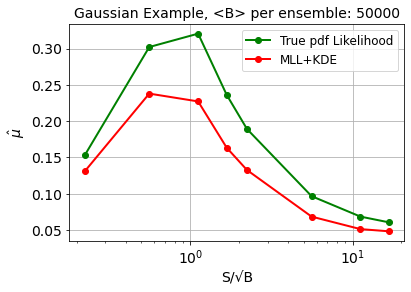

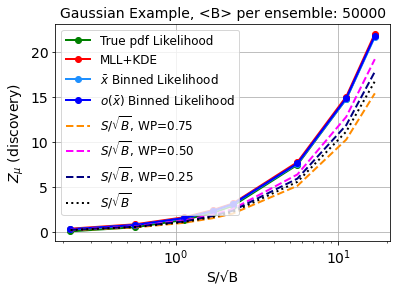

In [30]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()






plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ Binned Likelihood') 
plt.plot(posX, SrootB_WP2, '--', color='darkorange', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[2] )
plt.plot(posX, SrootB_WP1, '--', color='magenta', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[1] )
plt.plot(posX, SrootB_WP0, '--', color='navy', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[0] )
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

Substituting symbol N from STIXNonUnicode
Substituting symbol N from STIXNonUnicode
Substituting symbol N from STIXNonUnicode
Substituting symbol N from STIXNonUnicode


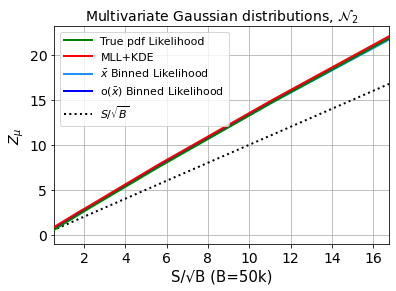

In [31]:
# FINAL PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-', color='green', lw=lw, label=r'True pdf Likelihood', zorder=5)
plt.plot(posX, store_Z_MLL_KDE, '-', color='red', lw=lw, label=r'MLL+KDE', zorder=5)
plt.plot(posX, store_Z_bins, '-', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood') 
plt.plot(posX, store_Z_bins_class, '-', color='blue', lw=lw, label=r'o$(\bar{x})$ Binned Likelihood') 
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')



plt.xlim([posX[1], posX[-1]])
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xlabel('S/√B (B=50k)', fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.grid()


plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.legend(loc="upper left", fontsize=11, handlelength=2.5)
#plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-example-2.pdf', format="pdf", bbox_inches="tight")
plt.show()